# CNN v3.0

Using CNN to try to buy and sell movements

In [1]:
import os
import json
import time
import pandas as pd
import math
import matplotlib.pyplot as plt
from cnn_prediction.cnn_data_loader_buy_sell import CNNDataLoaderBuySell
from cnn_prediction.cnn_model import CNNModel
import numpy as np
from core.utils import get_accuracy, plot_loss

Using TensorFlow backend.


## Load config

In [2]:
configs = json.load(open('predict-cnn-buy-sell-EURUSD-config.json', 'r'))

In [3]:
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])
pre_trained_model_filepath = configs['model']['pre_trained_model']
# pre_trained_model_filepath = None
generative_training = configs['model']['generative_training']
img_size = len(configs['data']['intervals'])

## Load data

In [4]:
cols = []
for indicator in configs['data']['technical_indicators']:
    for interval in configs['data']['intervals']:
        cols.append(indicator + '_' + str(interval))

In [7]:
dataloader = CNNDataLoaderBuySell(
    pd.read_csv('data/duka/' + configs['data']['filename'], index_col=0),
    indicators=configs['data']['technical_indicators'],
    intervals=configs['data']['intervals'],
    df_test=pd.read_csv('data/duka/'+ configs['data']['test_file'], index_col=0),
    window_size=10
)

In [8]:
dataloader.dataframe.head()

,Open,Close,High,Low,Volume,SMA_2,SMA_3,SMA_4,SMA_5,SMA_7,...,AROONOSC_9,AROONOSC_11,AROONOSC_13,AROONOSC_17,AROONOSC_21,AROONOSC_34,AROONOSC_41,AROONOSC_55,AROONOSC_77,AROONOSC_99
time,,,,,,,,,,,,,,,,,,,,,
2004-01-09 04:30:00,1.27597,1.27508,1.27617,1.27494,0,-0.000465,-0.000610,-0.000728,-0.000740,-0.000857,...,-1.000000,-0.909091,-0.769231,-0.588235,0.428571,0.705882,0.707317,0.527273,0.376623,0.292929
2004-01-09 05:00:00,1.27510,1.27304,1.27542,1.27240,0,-0.001020,-0.001670,-0.001988,-0.002214,-0.002457,...,-0.888889,-1.000000,-0.846154,-0.647059,-0.523810,0.676471,0.707317,0.527273,0.376623,0.292929
2004-01-09 05:30:00,1.27280,1.27310,1.27400,1.27114,0,0.000030,-0.000640,-0.001208,-0.001542,-0.001934,...,-1.000000,-1.000000,-0.923077,-0.705882,-0.571429,0.647059,0.707317,0.527273,0.376623,0.292929
2004-01-09 06:00:00,1.27291,1.27338,1.27432,1.27260,0,0.000140,0.000207,-0.000270,-0.000742,-0.001299,...,-0.888889,-0.818182,-0.923077,-0.705882,-0.571429,0.617647,0.682927,0.527273,0.376623,0.292929
2004-01-09 06:30:00,1.27352,1.27312,1.27371,1.27160,0,-0.000130,-0.000080,-0.000040,-0.000424,-0.001124,...,-0.666667,-0.818182,-0.846154,-0.705882,-0.571429,0.588235,0.609756,0.527273,0.376623,0.292929


In [9]:
x_train, y_train = dataloader.get_train_data(cols, window_size=15)
x_test, y_test  = dataloader.get_test_data(cols, window_size=15)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

 91%|█████████ | 10000/11043 [00:00<00:00, 129126.63it/s]


((78543, 15, 15, 3), (78543,), (5640, 15, 15, 3), (5640,))

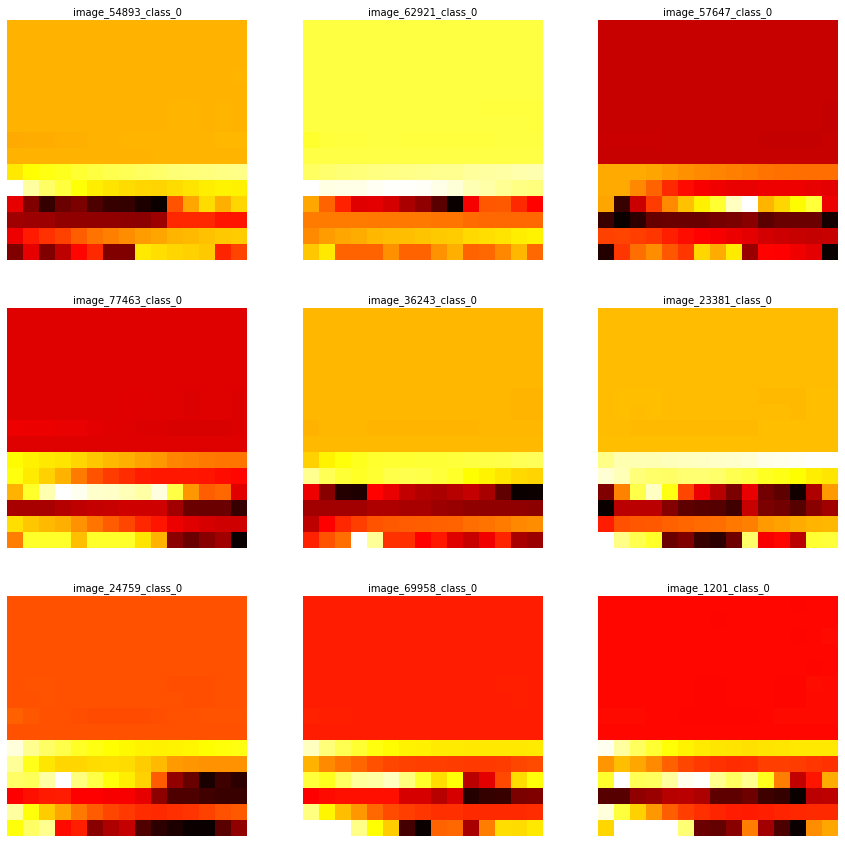

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img, cmap='hot', interpolation='nearest')
plt.show()

### Print labels

In [11]:
close = dataloader.dataframe["Close"].values
labels = dataloader.train_labels
size = 200
closes = close[:size]

states_buy = []
states_sell = []

for i in range(size):
    if labels[i] == 1: states_buy.append(i)
    if labels[i] == 2: states_sell.append(i)

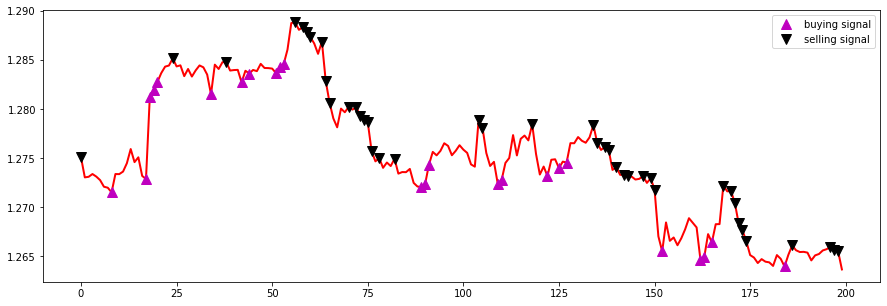

In [12]:
fig = plt.figure(figsize = (15,5))
plt.plot(closes, color='r', lw=2.)
plt.plot(closes, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(closes, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.show()

## Model
### Load Model

In [17]:
model = CNNModel()

if pre_trained_model_filepath:
    print("Loading model => ", pre_trained_model_filepath)
    model.load_model('saved_models/' + pre_trained_model_filepath)
    model.model.load_weights('saved_models/' + configs['model']['pre_trained_weights'])
    model.model.summary()
else:
    model.create_model_cnn(
        configs['model'], 
        input_shape=(x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2])
    )

Loading model =>  cnn-EURUSD_buy_sell_w10-ep500-2020_06_11.model
[Model] Loading model from file saved_models/cnn-EURUSD_buy_sell_w10-ep500-2020_06_11.model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (N

### Training

In [18]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.set_session(tf.Session(graph=model.model.output.graph))
init = tf.global_variables_initializer()
K.get_session().run(init)

In [24]:
%%time

if not generative_training:
    print("In memory training")
    hist = model.train(
        x_train,
        y_train,
        epochs=configs['model']['epochs'],
        batch_size=configs['model']['batch_size'],
        save_dir=configs['model']['save_dir'],
        x_val=x_test,
        y_val=y_test,
        verbose=True
    )
else:
    print("Out of memory training...")
    steps_per_epoch = math.ceil(dataloader.len_train / configs['model']['batch_size'])
    validation_steps = math.ceil(dataloader.len_test / configs['model']['batch_size'])
    hist = model.train_generator(
        data_gen=dataloader.generate_train_batch(
            cols,
            batch_size=configs['model']['batch_size'],
            window_size=img_size
        ),
        epochs=configs['model']['epochs'],
        batch_size=configs['model']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir'],
        validation_data=dataloader.generate_test_batch(
            cols,
            batch_size=configs['model']['batch_size'],
            window_size=img_size
        ),
        validation_steps=validation_steps
    )

In memory training
[Model] Training Started
[Model] 2 epochs, 32 batch size
Train on 78543 samples, validate on 5640 samples
Epoch 1/2
78543/78543 [==============================] - 26s 333us/sample - loss: 1.1050 - acc: 0.3513 - f1_score: 2.7317 - precision: 0.1071 - recall: 0.0037 - val_loss: 1.0983 - val_acc: 0.3619 - val_f1_score: 2.9928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
78543/78543 [==============================] - 26s 335us/sample - loss: 1.0988 - acc: 0.3607 - f1_score: 2.9106 - precision: 0.0065 - recall: 2.1938e-04 - val_loss: 1.0978 - val_acc: 0.3635 - val_f1_score: 2.9892 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
[Model] Training Completed. Model saved as saved_models/cnn-25072020-214942-e2.h5
CPU times: user 1min 58s, sys: 13.3 s, total: 2min 11s
Wall time: 52.5 s


Loss


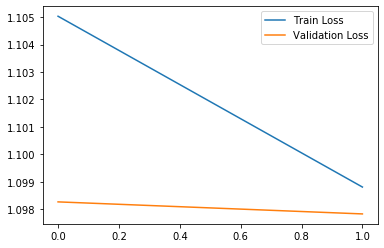

Accuracy


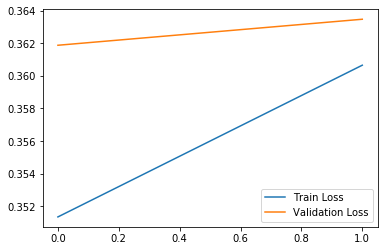

f1_score


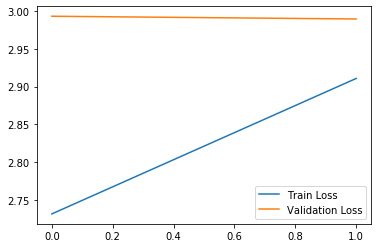

precision


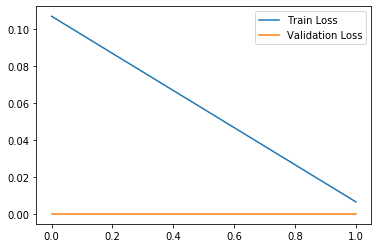

recall


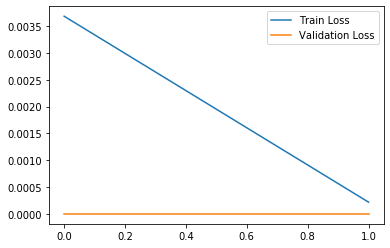

In [25]:
print("Loss")
plot_loss(hist.history['loss'], hist.history['val_loss'])
print("Accuracy")
plot_loss(hist.history['acc'], hist.history['val_acc'])
print("f1_score")
plot_loss(hist.history['f1_score'], hist.history['val_f1_score'])
print("precision")
plot_loss(hist.history['precision'], hist.history['val_precision'])
print("recall")
plot_loss(hist.history['recall'], hist.history['val_recall'])

## Evaluate

In [13]:
predictions_train = model.predict(x_train,verbose=True)
predictions_test = model.predict(x_test,verbose=True)

5640/5640 [==============================] - 0s 88us/sample


In [14]:
predictions_train = np.argmax(predictions_train, axis=1)
predictions_test = np.argmax(predictions_test, axis=1)

In [15]:
pred_right_train = np.array(predictions_train == y_train)
pred_right_test = np.array(predictions_test == y_test)

In [16]:
print("Train acc ", np.sum(pred_right_train) / pred_right_train.shape[0] * 100.0 )
print("Test acc ", np.sum(pred_right_test) / pred_right_test.shape[0] * 100.0 )

Train acc  40.00229173828348
Test acc  38.297872340425535
